In [ ]:
%autosave 300
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [ ]:
import os

os.chdir("../..")
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/soutrik-vm-dev/code/Users/Soutrik.Chowdhury/langgraph_ventures


Accommodate conversation-style interactions and multi-step retrieval processes.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [3]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [4]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

embedding_dim = len(embeddings.embed_query("hello world"))
print(embedding_dim)
index = faiss.IndexFlatL2(embedding_dim)

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

3072


In [5]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [27]:
from langgraph.graph import START, StateGraph, END, MessagesState
from typing_extensions import List, TypedDict, Annotated
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition

In [8]:
# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

In [9]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)
all_splits = text_splitter.split_documents(docs)
print(f"Split into {len(all_splits)} chunks")

Split into 66 chunks


In [10]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

User input as a HumanMessage\
Vector store query as an AIMessage with tool calls\
Retrieved documents as a ToolMessage\
Final response as a AIMessage.

In this module we will define the retriever under a tool, so the model knows when to call it and when to stop.

In [31]:
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query only when the query deals with AI agents and tools."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

Our graph will consist of three nodes:

A node that fields the user input, either generating a query for the retriever or responding directly\
A node for the retriever tool that executes the retrieval step\
A node that generates the final response using the retrieved context.

In [32]:
# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state:MessagesState):
    """ Generate an AIMessage that may include a tool-call to be sent. """
    llm_with_tool = llm.bind_tools([retrieve])
    response = llm_with_tool.invoke(state['messages'])
    return {"messages":[response]}

In [33]:
# execute if tool is called - A node that runs the tools called in the last AIMessage.
tools = ToolNode([retrieve])

In [39]:
# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer using the retrieved content."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    print(f"Prompt: {prompt}")

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [ ]:
# Build and compile the graph
graph_builder = StateGraph(MessagesState)
# adding nodes
graph_builder.add_node("query_or_respond",query_or_respond)
graph_builder.add_node("tools",tools)
graph_builder.add_node("generate",generate)
# adding edges
graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(source = 'query_or_respond',
                                    path= tools_condition, 
                                    path_map={"tools": "tools",END:END}
                                    )
graph_builder.add_edge("tools",'generate')
graph_builder.add_edge("generate", END)

In [ ]:

# compile the graph
graph = graph_builder.compile()

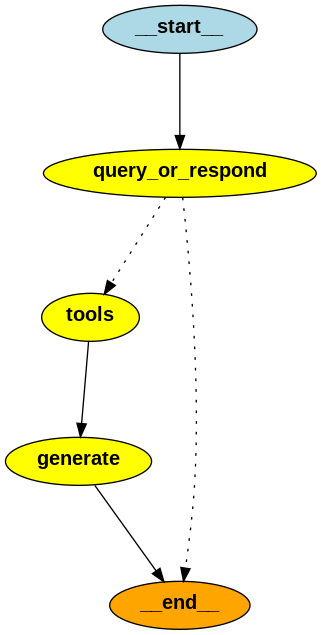

In [41]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_png()))

In [44]:
input_message ="What is the capital of France?"

In [48]:
result = await graph.ainvoke({"messages": [{"role": "user", "content": input_message}]})

In [53]:
display(result['messages'][-1].content)

'The capital of France is Paris.'

In [58]:
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is the capital of France?


================================== Ai Message ==================================

The capital of France is Paris.


In [59]:
async for step in graph.astream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'query_or_respond': {'messages': [AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 60, 'total_tokens': 69, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_64e0ac9789', 'finish_reason': 'stop', 'logprobs': None}, id='run-d254582c-9423-4abd-b185-b5f7efd262db-0', usage_metadata={'input_tokens': 60, 'output_tokens': 9, 'total_tokens': 69, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}

----------------



In [63]:
input_message = "What is Task Decomposition as a concept in AI agents?"
result = await graph.ainvoke({"messages": [{"role": "user", "content": input_message}]})

Prompt: [SystemMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, say that you don't know. Use three sentences maximum and keep the answer concise.\n\nSource: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}\nContent: Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\n\nSource: {'so

In [64]:
for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================

What is Task Decomposition as a concept in AI agents?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_XOqDbjPgn9KiKmjvEEjHgLqe)
 Call ID: call_XOqDbjPgn9KiKmjvEEjHgLqe
  Args:
    query: Task Decomposition in AI agents
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose

#### Next we add persistent local memory to the graph

In [69]:
from langgraph.checkpoint.memory import MemorySaver
import uuid

In [70]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [71]:
# Specify an ID for the thread
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

In [72]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_tpuy7elV4PVTLvI42eywAEoZ)
 Call ID: call_tpuy7elV4PVTLvI42eywAEoZ
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler st

In [73]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_bwNFtLwa2922V4zZyTJTIAH0)
 Call ID: call_bwNFtLwa2922V4zZyTJTIAH0
  Args:
    query: common ways of task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard 

#### How to get your RAG application to return sources

In [84]:
class State(MessagesState):
    context: List[Document]

In [85]:
# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: State):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])

In [86]:
# Updating step3: Generate a response using the retrieved content.
def generate(state: State):
    """Generate answer using the retrieved content."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    print(f"Prompt: {prompt}")

    # Run
    response = llm.invoke(prompt)
    context = []
    for tool_message in tool_messages:
        context.extend(tool_message.artifact)
    return {"messages": [response] , "context": context}

In [87]:
# Build and compile the graph
graph_builder = StateGraph(State)
# adding nodes
graph_builder.add_node("query_or_respond",query_or_respond)
graph_builder.add_node("tools",tools)
graph_builder.add_node("generate",generate)
# adding edges
graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(source = 'query_or_respond',
                                    path= tools_condition, 
                                    path_map={"tools": "tools",END:END}
                                    )
graph_builder.add_edge("tools",'generate')
graph_builder.add_edge("generate", END)

In [88]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
# Specify an ID for the thread
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

In [90]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_0R8peKnDgSZzCT9RVE81SGz7)
 Call ID: call_0R8peKnDgSZzCT9RVE81SGz7
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler st

In [91]:
step["context"]

[Document(id='9e23952e-3263-41cc-b502-40da149edf47', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'),
 Document(id='b80e54a4-57fe-4f1e-9198-a734546831d9', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by explor

In [92]:
op = await graph.ainvoke(
    {"messages": [{"role": "user", "content": input_message}]},
    config=config,
)

In [96]:
op['messages'][-1]

AIMessage(content='Task Decomposition is the process of breaking down a complex task into smaller, more manageable sub-tasks or steps. This technique is particularly useful in problem-solving and planning, as it allows for a structured approach to handling intricate challenges. \n\nIn the context of AI and machine learning, methods like Chain of Thought (CoT) prompting are used to encourage models to think through the problem step by step. This not only improves the performance of models on complex tasks but also provides insights into their reasoning processes. \n\nAdditionally, Task Decomposition can be performed through various means:\n1. Simple prompting, such as asking for the steps needed to accomplish a task.\n2. Task-specific instructions designed to guide the model on how to approach a particular type of task.\n3. Inputs and guidance from humans to further refine the decomposition process.\n\nOverall, Task Decomposition enables clearer understanding and more efficient executio

In [97]:
op = await graph.ainvoke(
    {"messages": [{"role": "user", "content": "Who is the author for the same?"}]},
    config=config,
)

In [98]:
for message in op['messages']:
    message.pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_0R8peKnDgSZzCT9RVE81SGz7)
 Call ID: call_0R8peKnDgSZzCT9RVE81SGz7
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler st

######################################################## END ###########################################################